In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.convnet import train_net, NumNet

import matplotlib.pyplot as plt

In [3]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

In [4]:
#import data for a 1000 pairs
N = 1000
#dataset_train = DlDataset(N, normalize=True, upsample=(28,28))
#dataset_test = DlDataset(N, normalize=True, upsample=(28,28))
dataset_train = DlDataset(N, normalize=True, upsample=None)
dataset_test = DlDataset(N, normalize=True, upsample=None)

dataset_train.train()
dataset_test.test()

datasetShape = list(dataset_train.__shape__()[1:])

In [5]:
#model, simple cnn with 2 conv layers and one hidden and output layer
#Number of parameters 224290
class Net(nn.Module):
    def __init__(self,hiddenUnits):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, hiddenUnits)
        self.fc2 = nn.Linear(hiddenUnits, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.drop1(x)
        x = self.bn2(x)        
        x = F.relu(self.fc1(x.view(-1, 64*5*5)))
        #x = self.drop2(x)
        #x = self.fc2(x)
        x = F.log_softmax(self.fc2(x),dim=1)
        return x

In [6]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
config = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':2, 'activation':'LogSoftmax(dim=1)'}]



In [7]:
#Initialize model
model = NumNet(datasetShape, config)
model.summary()
# Train parameter
epochs = 30
eta = 5e-3
#lambda_l2 = 1e-3
gamma = 0.2
#depth = 4
#n_filters = 3

# U-Net definition
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 
#model = Net(128).to(device)
optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
criterion = torch.nn.CrossEntropyLoss()
dataloader = []
dataloader.append(DataLoader(dataset_train, batch_size=10,shuffle=True, num_workers=4))
dataloader.append(DataLoader(dataset_test, batch_size=10,shuffle=True, num_workers=4))

avg_loss_train,avg_acc_train,avg_loss_test,avg_acc_test, model = train_net(model, device, optim, criterion, dataloader,
                                                     epochs=epochs, lambda_=1e-3, reg_type=None, 
                                                     save=False)

Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [32, 10, 10]        1632
1                   MaxPool2d           [32, 10, 10]        [32, 5, 5]          0
2                   BatchNorm2d         [32, 5, 5]          [32, 5, 5]          64
3                   Dropout2d           [32, 5, 5]          [32, 5, 5]          0
4                   Conv2d              [32, 5, 5]          [64, 3, 3]          18496
5                   BatchNorm2d         [64, 3, 3]          [64, 3, 3]          128
6                   Linear              576                 128                 73856
7                   Linear              128                 2                   258
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 94434
----------------------------------------------------------------------------------

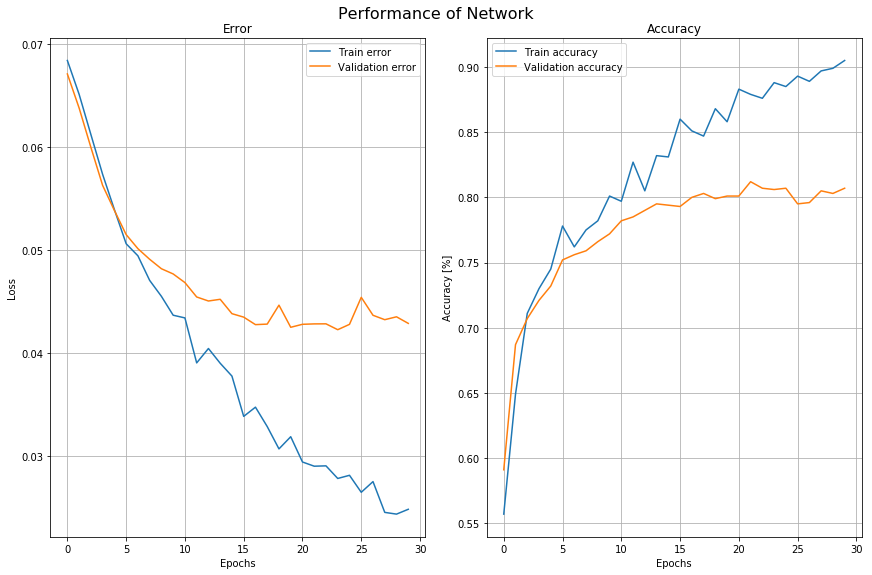

In [8]:
fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(12,8))
fig.suptitle('Performance of Network', fontsize=16)
axs[0].plot(range(0,epochs), avg_loss_train, label = 'Train error')
axs[0].plot(range(0,epochs), avg_loss_test, label = 'Validation error')
axs[0].set_title('Error')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()
axs[0].legend()

axs[1].plot(range(0,epochs), avg_acc_train, label = 'Train accuracy')
axs[1].plot(range(0,epochs), avg_acc_test, label = 'Validation accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy [%]')
axs[1].grid()
axs[1].legend()

plt.show()
fig.savefig('Figure1.png')

Predicted Target: 1, Real Target: 1
Real classes are, left: 1 right: 2
Predicted Target: 0, Real Target: 0
Real classes are, left: 7 right: 1


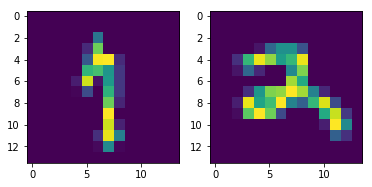

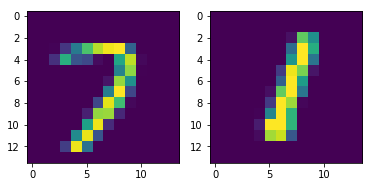

In [10]:
dataset_test.infere(model,5);
dataset_test.infere(model,6);